# 티웨이항공 사전 데이터 EDA

- 일자: 2022.08.22. ~ 08.31.
- 작업자: 김상욱

## 1. 데이터 불러오기

- 예약_20220822.csv, 쿠폰_20220822.csv, 비행편정보_20220822.csv

In [2]:
import pandas as pd
import sagemaker

sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()

In [3]:
bucket = 'poc-2209-twayairport-dp'

booking_df = pd.read_csv(f's3://{bucket}/data/original/예약_20220822.csv')
coupon_df = pd.read_csv(f's3://{bucket}/data/original/쿠폰_20220822.csv')
flight_df = pd.read_csv(f's3://{bucket}/data/original/비행편정보_20220822.csv')

In [4]:
booking_df.head()

,leg,flight_number,flight_departure_date,leg_departure_point,capture_date,airline_code,operating_airline_code,fare_class,cabin_code,parent_inventory_unit,group_sold_seats,sold_seats,available_seats,authorised_cap,fare_class_line
0,GMP-CJU,723,2022-08-22,GMP,2022-01-01,TW,TW,H,Y,I,0,0,10,10,국내선
1,GMP-CJU,723,2022-08-22,GMP,2022-01-01,TW,TW,L,Y,M,0,0,40,40,국내선
2,GMP-CJU,723,2022-08-22,GMP,2022-01-01,TW,TW,K,Y,L,0,0,30,30,국내선
3,GMP-CJU,723,2022-08-22,GMP,2022-01-01,TW,TW,J,Y,H,0,0,0,0,국내선
4,GMP-CJU,723,2022-08-22,GMP,2022-01-01,TW,TW,I,Y,K,0,0,20,20,국내선


In [5]:
coupon_df.head()

,ticketno,issuedate,cpnno,startseg,endseg,carrier,bookingclass,flightdate,flightno,fare,farevat,pfc,fsc,fscvat,cabinclass
0,7222156209406,20220420,1,GMP,CJU,TW,T,20220822,707,58900,5354,4000,9900,900,Y
1,7222156211479,20220420,2,CJU,GMP,TW,P,20220822,740,61900,5627,4000,9900,900,Y
2,7222156211481,20220420,2,CJU,GMP,TW,P,20220822,740,61900,5627,4000,9900,900,Y
3,7222403540697,20220421,2,CJU,GMP,TW,M,20220822,710,50900,4627,4000,9900,900,Y
4,7222403540698,20220421,2,CJU,GMP,TW,M,20220822,710,50900,4627,4000,9900,900,Y


In [6]:
flight_df.head()

,flight_number,flight_departure_date,leg,cabin_class,cabin_authorised_cap,leg_departure_date_time,leg_arrival_date_time
0,701,2022-08-22,GMP-CJU,Y,189,2022-08-22 06:40:00,2022-08-22 07:50:00
1,702,2022-08-22,CJU-GMP,Y,189,2022-08-22 07:55:00,2022-08-22 09:05:00
2,703,2022-08-22,GMP-CJU,Y,189,2022-08-22 07:00:00,2022-08-22 08:10:00
3,705,2022-08-22,GMP-CJU,C,12,2022-08-22 08:00:00,2022-08-22 09:15:00
4,705,2022-08-22,GMP-CJU,Y,335,2022-08-22 08:00:00,2022-08-22 09:15:00


In [7]:
# 데이터 크기, 형태 체크
print(f'예약데이터: {booking_df.shape}')
print(f'쿠폰데이터: {coupon_df.shape}')
print(f'비행편데이터: {flight_df.shape}')

예약데이터: (151848, 15)
쿠폰데이터: (6727, 15)
비행편데이터: (34, 7)


# 2. 데이터 가공

- 데이터 컬럼 포맷 변환
- 추가로 얻을 수 있는 정보
- 테이블 merge

## 2.1. 데이터 컬럼 포맷 변환
각 테이블 별로 동일한 값을 가지지만 컬럼명이 다르거나 그 포맷이 다른 경우 통일해 줌.

- booking_df.flight_number == coupon_df.flightno == flight_df.flight_number
- booking_df.flight_departure_date == coupon_df.flightdate = flight_df.flight_departure_date
- booking_df.capture_date == coupon_df.issuedate
- booking_df.airline_code == coupon_df.carrier
- booking_df.fare_class == coupon_df.bookingclass
- booking_df.cabin_code == coupon_df.cabinclass == flight_df.cabin_class

In [8]:
# 컬럼명 변경은 핵심적으로 사용할 coupon_df 기준으로 변경
booking_df.rename(columns={'flight_number': 'flightno',
                           'flight_departure_date': 'flightdate',
                           'capture_date': 'issuedate',
                           'airline_code': 'carrier',
                           'fare_class': 'bookingclass',
                           'cabin_code': 'cabinclass'}, inplace=True)

flight_df.rename(columns={'flight_number': 'flightno',
                          'flight_departure_date': 'flightdate',
                          'cabin_class': 'cabinclass'}, inplace=True)

print('')

In [9]:
# 날짜 데이터 형변환
booking_df['flightdate'] = pd.to_datetime(booking_df['flightdate'], format='%Y-%m-%d')
booking_df['issuedate'] = pd.to_datetime(booking_df['issuedate'], format='%Y-%m-%d')
coupon_df['flightdate'] = pd.to_datetime(coupon_df['flightdate'], format='%Y%m%d')
coupon_df['issuedate'] = pd.to_datetime(coupon_df['issuedate'], format='%Y%m%d')
flight_df['flightdate'] = pd.to_datetime(flight_df['flightdate'], format='%Y-%m-%d')
flight_df['leg_departure_date_time'] = pd.to_datetime(flight_df['leg_departure_date_time'])
flight_df['leg_arrival_date_time'] = pd.to_datetime(flight_df['leg_arrival_date_time'])

## 2.2. 추가로 얻을 수 있는 정보

- 예약데이터: 판매좌석 (잔여좌석은 음수가 발생)
- 쿠폰데이터: 출항까지 잔여일수

### 2.2.1. 예약데이터 판매좌석 수

In [10]:
# 누적판매좌석 추출
seats_df = pd.DataFrame({'total_sold_seats' : booking_df.groupby(["flightno", "issuedate", 'cabinclass'])['sold_seats'].sum()}).reset_index()
seats_df.head()

,flightno,issuedate,cabinclass,total_sold_seats
0,701,2022-01-01,Y,0
1,701,2022-01-02,Y,0
2,701,2022-01-03,Y,0
3,701,2022-01-04,Y,0
4,701,2022-01-05,Y,0


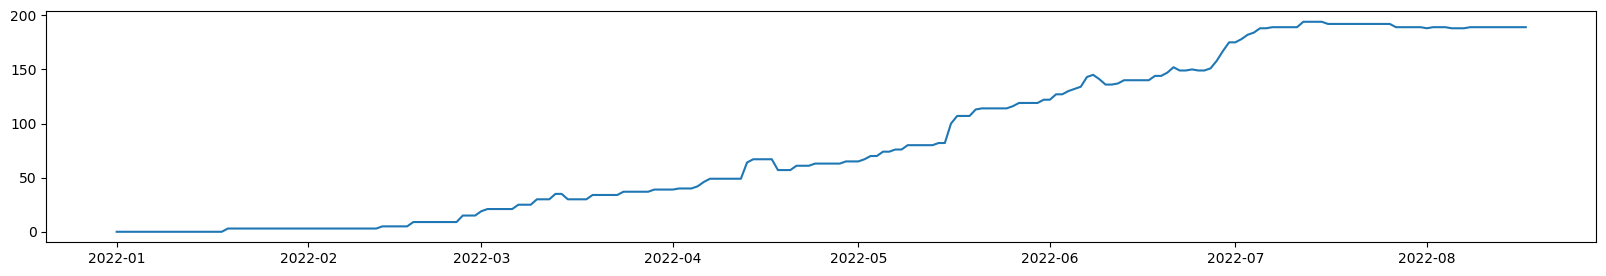

In [11]:
# 임의로 713 항공편에 대해서 누적예매 분포를 확인
import matplotlib.pyplot as plt

plt.figure(figsize=(20,3))
plt.plot(seats_df[(seats_df['flightno'] == 713) & (seats_df['cabinclass'] == 'Y')]['issuedate']
         , seats_df[(seats_df['flightno'] == 713) & (seats_df['cabinclass'] == 'Y')]['total_sold_seats'])
plt.show()

- 예매 취소가 발생하는 것을 확인할 수 있음

In [12]:
# 항공편 데이터와 merge
seats_df = pd.merge(seats_df, flight_df[['flightno', 'cabinclass', 'cabin_authorised_cap']], on=['flightno', 'cabinclass'], how='left')
seats_df.head()

,flightno,issuedate,cabinclass,total_sold_seats,cabin_authorised_cap
0,701,2022-01-01,Y,0,189.0
1,701,2022-01-02,Y,0,189.0
2,701,2022-01-03,Y,0,189.0
3,701,2022-01-04,Y,0,189.0
4,701,2022-01-05,Y,0,189.0


In [13]:
# 최대 배정 좌석수가 비행기가 수용할 수 있는 인원에 맞는지 확인
seats_df.groupby(['flightno', 'cabinclass', 'cabin_authorised_cap'])['total_sold_seats'].max()

flightno  cabinclass  cabin_authorised_cap
701       Y           189.0                   172
702       Y           189.0                   134
703       Y           189.0                   155
705       C           12.0                      6
          Y           335.0                   335
706       Y           189.0                   103
707       Y           189.0                   189
708       C           12.0                      2
          Y           335.0                   189
710       Y           189.0                   132
713       Y           189.0                   194
715       Y           189.0                   189
717       C           12.0                      2
          Y           335.0                   287
718       Y           189.0                   124
720       Y           189.0                   129
722       C           12.0                      2
          Y           335.0                   335
723       Y           189.0                   156
725    

- 713번 항공편의 경우에 전체 최대 허용치보다 높게 잡힌 데이터를 확인
- 당일에 예매하고 취소하고 다시 예매가 발생하면, 위와 같은 이상치가 발생할 수 있을 듯.

### 2.2.2. 쿠폰데이터 출항까지 잔여일수

In [14]:
coupon_df['remaindate'] = coupon_df['flightdate'] - coupon_df['issuedate']

In [15]:
coupon_df.head()

,ticketno,issuedate,cpnno,startseg,endseg,carrier,bookingclass,flightdate,flightno,fare,farevat,pfc,fsc,fscvat,cabinclass,remaindate
0,7222156209406,2022-04-20,1,GMP,CJU,TW,T,2022-08-22,707,58900,5354,4000,9900,900,Y,124 days
1,7222156211479,2022-04-20,2,CJU,GMP,TW,P,2022-08-22,740,61900,5627,4000,9900,900,Y,124 days
2,7222156211481,2022-04-20,2,CJU,GMP,TW,P,2022-08-22,740,61900,5627,4000,9900,900,Y,124 days
3,7222403540697,2022-04-21,2,CJU,GMP,TW,M,2022-08-22,710,50900,4627,4000,9900,900,Y,123 days
4,7222403540698,2022-04-21,2,CJU,GMP,TW,M,2022-08-22,710,50900,4627,4000,9900,900,Y,123 days


## 2.3. 테이블 merge

- 주요 테이블인 coupon_df 기준으로 테이블 합치기

In [16]:
# 우선 비행편 정보 합치기 - 필요한 데이터 cabin_authorised_cap, leg_departure_date_time, leg_arrival_date_time
flight_columns = ['flightno', 'cabinclass', 'cabin_authorised_cap', 'leg_departure_date_time', 'leg_arrival_date_time']
new_coupon_df = pd.merge(coupon_df, flight_df[flight_columns], on=['flightno', 'cabinclass'], how='left')
new_coupon_df.head()

,ticketno,issuedate,cpnno,startseg,endseg,carrier,bookingclass,flightdate,flightno,fare,farevat,pfc,fsc,fscvat,cabinclass,remaindate,cabin_authorised_cap,leg_departure_date_time,leg_arrival_date_time
0,7222156209406,2022-04-20,1,GMP,CJU,TW,T,2022-08-22,707,58900,5354,4000,9900,900,Y,124 days,189.0,2022-08-22 09:45:00,2022-08-22 10:55:00
1,7222156211479,2022-04-20,2,CJU,GMP,TW,P,2022-08-22,740,61900,5627,4000,9900,900,Y,124 days,189.0,2022-08-22 18:10:00,2022-08-22 19:15:00
2,7222156211481,2022-04-20,2,CJU,GMP,TW,P,2022-08-22,740,61900,5627,4000,9900,900,Y,124 days,189.0,2022-08-22 18:10:00,2022-08-22 19:15:00
3,7222403540697,2022-04-21,2,CJU,GMP,TW,M,2022-08-22,710,50900,4627,4000,9900,900,Y,123 days,189.0,2022-08-22 11:05:00,2022-08-22 12:15:00
4,7222403540698,2022-04-21,2,CJU,GMP,TW,M,2022-08-22,710,50900,4627,4000,9900,900,Y,123 days,189.0,2022-08-22 11:05:00,2022-08-22 12:15:00


In [17]:
new_coupon_df[new_coupon_df['leg_departure_date_time'].isna()]['flightno'].value_counts()

734    34
727    13
712    11
Name: flightno, dtype: int64

- 쿠폰데이터에 있는 항공편이 항공편데이터에 없는 케이스 존재
- 위 데이터 결측치로 생각하고 제거

In [18]:
print(len(new_coupon_df))
new_coupon_df = new_coupon_df.dropna()
print(len(new_coupon_df))

6727
6669


- 예약데이터의 경우 전체데이터를 매핑하는 것은 무의미함.
- 판매좌석 추출을 진행했던 seats_df를 사용

In [19]:
new_coupon_df.head()

,ticketno,issuedate,cpnno,startseg,endseg,carrier,bookingclass,flightdate,flightno,fare,farevat,pfc,fsc,fscvat,cabinclass,remaindate,cabin_authorised_cap,leg_departure_date_time,leg_arrival_date_time
0,7222156209406,2022-04-20,1,GMP,CJU,TW,T,2022-08-22,707,58900,5354,4000,9900,900,Y,124 days,189.0,2022-08-22 09:45:00,2022-08-22 10:55:00
1,7222156211479,2022-04-20,2,CJU,GMP,TW,P,2022-08-22,740,61900,5627,4000,9900,900,Y,124 days,189.0,2022-08-22 18:10:00,2022-08-22 19:15:00
2,7222156211481,2022-04-20,2,CJU,GMP,TW,P,2022-08-22,740,61900,5627,4000,9900,900,Y,124 days,189.0,2022-08-22 18:10:00,2022-08-22 19:15:00
3,7222403540697,2022-04-21,2,CJU,GMP,TW,M,2022-08-22,710,50900,4627,4000,9900,900,Y,123 days,189.0,2022-08-22 11:05:00,2022-08-22 12:15:00
4,7222403540698,2022-04-21,2,CJU,GMP,TW,M,2022-08-22,710,50900,4627,4000,9900,900,Y,123 days,189.0,2022-08-22 11:05:00,2022-08-22 12:15:00


In [20]:
seats_df.head()

,flightno,issuedate,cabinclass,total_sold_seats,cabin_authorised_cap
0,701,2022-01-01,Y,0,189.0
1,701,2022-01-02,Y,0,189.0
2,701,2022-01-03,Y,0,189.0
3,701,2022-01-04,Y,0,189.0
4,701,2022-01-05,Y,0,189.0


In [21]:
seats_columns = ['flightno', 'issuedate', 'cabinclass', 'total_sold_seats']
new_coupon_df = pd.merge(new_coupon_df, seats_df[seats_columns], on=['flightno', 'issuedate', 'cabinclass'], how='left')

In [22]:
new_coupon_df.head()

,ticketno,issuedate,cpnno,startseg,endseg,carrier,bookingclass,flightdate,flightno,fare,farevat,pfc,fsc,fscvat,cabinclass,remaindate,cabin_authorised_cap,leg_departure_date_time,leg_arrival_date_time,total_sold_seats
0,7222156209406,2022-04-20,1,GMP,CJU,TW,T,2022-08-22,707,58900,5354,4000,9900,900,Y,124 days,189.0,2022-08-22 09:45:00,2022-08-22 10:55:00,91.0
1,7222156211479,2022-04-20,2,CJU,GMP,TW,P,2022-08-22,740,61900,5627,4000,9900,900,Y,124 days,189.0,2022-08-22 18:10:00,2022-08-22 19:15:00,44.0
2,7222156211481,2022-04-20,2,CJU,GMP,TW,P,2022-08-22,740,61900,5627,4000,9900,900,Y,124 days,189.0,2022-08-22 18:10:00,2022-08-22 19:15:00,44.0
3,7222403540697,2022-04-21,2,CJU,GMP,TW,M,2022-08-22,710,50900,4627,4000,9900,900,Y,123 days,189.0,2022-08-22 11:05:00,2022-08-22 12:15:00,8.0
4,7222403540698,2022-04-21,2,CJU,GMP,TW,M,2022-08-22,710,50900,4627,4000,9900,900,Y,123 days,189.0,2022-08-22 11:05:00,2022-08-22 12:15:00,8.0


In [23]:
new_coupon_df['issueweekday'] = new_coupon_df['issuedate'].dt.weekday

In [24]:
# QuickSight 분석용 데이터 저장
#new_coupon_df.to_csv(f's3://{bucket}/data/etc/transform.csv')

# 3. 데이터 EDA

우선 전달 받은 데이터로 확인해볼만한 분포를 체크
- 시간에 따른 가격 변동 / 판매수 / 누적판매수
- 도착 시간에 따른 판매 건수, 수익

In [25]:
flightno_list = new_coupon_df['flightno'].unique()
flightno_189_list = new_coupon_df[new_coupon_df['cabin_authorised_cap'] == 189]['flightno'].unique()
flightno_335_list = new_coupon_df[new_coupon_df['cabin_authorised_cap'] == 335]['flightno'].unique()

## 3.1. 시간에 따른 누적 판매수 분포

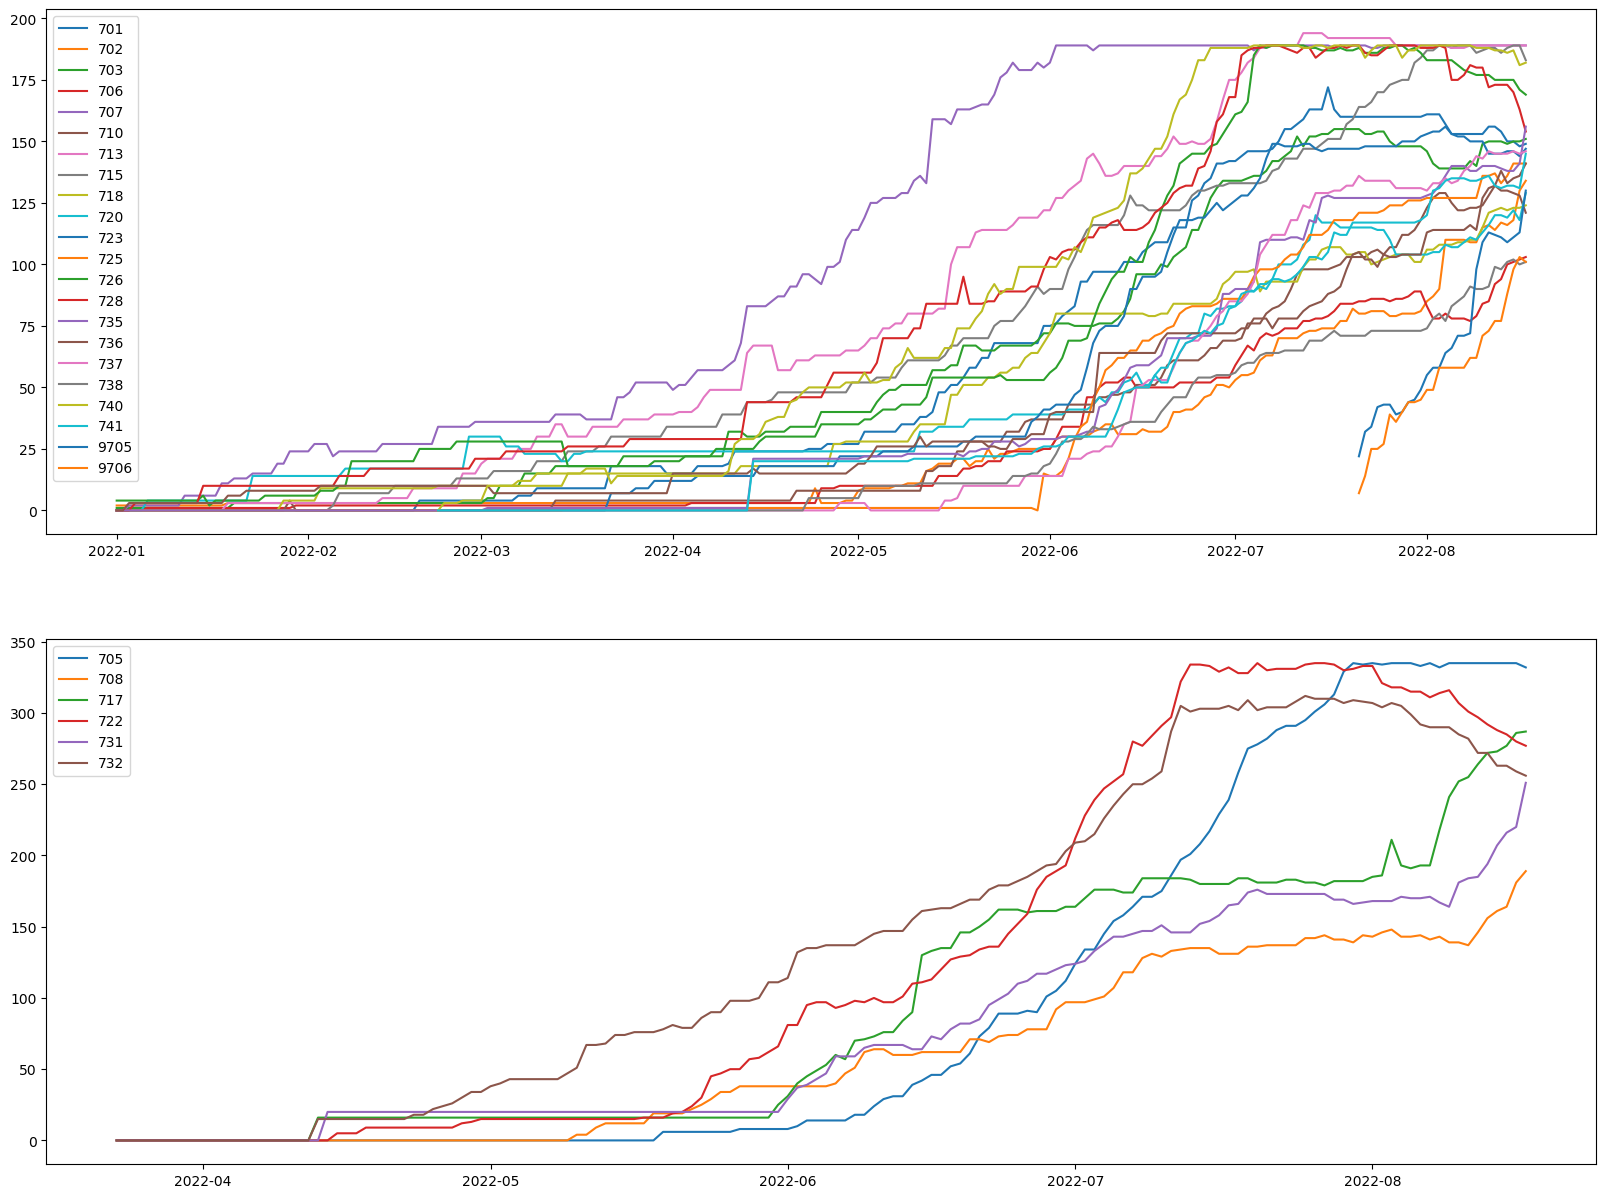

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,15))
ax1 = plt.subplot(2, 1, 1)
ax2 = plt.subplot(2, 1, 2)

for flightno in sorted(flightno_list):
#for flightno in [701]:    
    try:
        if flightno in flightno_189_list:
            ax1.plot(seats_df[(seats_df['flightno'] == flightno) & (seats_df['cabinclass'] == 'Y')]['issuedate']
                     , seats_df[(seats_df['flightno'] == flightno) & (seats_df['cabinclass'] == 'Y')]['total_sold_seats']
                     , label=str(flightno))
        else:
            ax2.plot(seats_df[(seats_df['flightno'] == flightno) & (seats_df['cabinclass'] == 'Y')]['issuedate']
                     , seats_df[(seats_df['flightno'] == flightno) & (seats_df['cabinclass'] == 'Y')]['total_sold_seats']
                     , label=str(flightno))
    except Exception as e:
        print(flightno)
        print(e)

plt.subplot(ax1)
plt.legend()
plt.subplot(ax2)
plt.legend()
plt.savefig('time_sold.png')
plt.show()

- 비행기 출항 (8월) 3달전인 5월부터 6월에 그래프가 상승하는 추세를 보이며 마지막 7,8월에는 다시 완만한 형태를 확인할 수 있음.

## 3.2. 시간에 따른 가격 변동

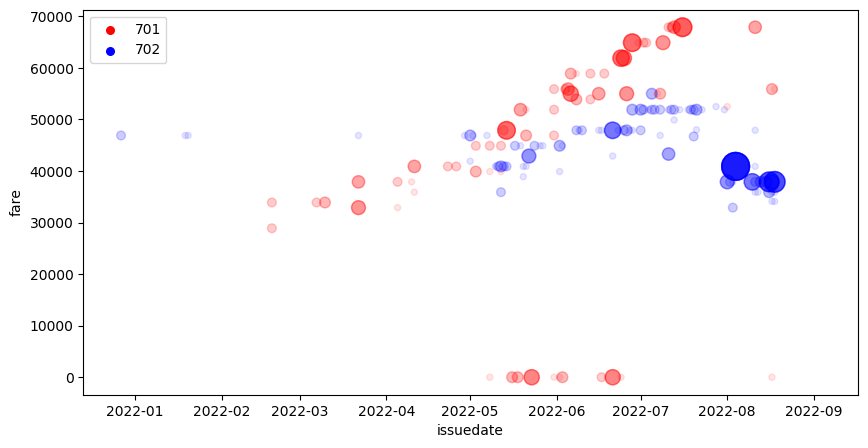

In [93]:
import matplotlib.pyplot as plt
from importlib import reload
from collections import Counter

plt=reload(plt)

plt.figure(figsize=(10,5))

colors = ['red', 'blue']

#for flightno in sorted(flightno_list):
for idx, flightno in enumerate([701, 702]): # 단일항공편 확인시
    try:
        x = new_coupon_df[new_coupon_df['flightno'] == flightno]['issuedate']
        y = new_coupon_df[new_coupon_df['flightno'] == flightno]['fare']
        
        # x = new_coupon_df[(new_coupon_df['flightno'] == flightno) & (new_coupon_df['bookingclass'].isin(economic))]['issuedate']
        # y = new_coupon_df[(new_coupon_df['flightno'] == flightno) & (new_coupon_df['bookingclass'].isin(economic))]['fare']
        
        temp_list = []

        for i in range(len(x)):
            temp_list.append((x.iloc[i], y.iloc[i]))

        temp_list2 = [Counter(temp_list)[temp_list[i]]*20 for i in range(len(temp_list))]
        plt.scatter(x, y, alpha=0.1, s=temp_list2, label=str(flightno), c=colors[idx])
        
        #plt.scatter(x, y, s=temp_list2, label=str(flightno), c=colors[idx])
    except Exception as e:
        print(flightno)
        print(e)

plt.xlabel("issuedate")
plt.ylabel("fare")
lgnd = plt.legend(loc='upper left')
lgnd.legendHandles[0].set_alpha(1)
lgnd.legendHandles[1].set_alpha(1)
lgnd.legendHandles[0].set_sizes([30])
lgnd.legendHandles[1].set_sizes([30])
plt.show()

In [70]:
# from collections import Counter

# x = new_coupon_df[new_coupon_df['flightno'] == flightno]['issuedate']
# y = new_coupon_df[new_coupon_df['flightno'] == flightno]['fare']

# temp_list = []

# for i in range(len(x)):
#     temp_list.append((x.iloc[i], y.iloc[i]))
    
# Counter(temp_list)

# # temp_list2 = [i in Counter(temp_list)[temp_list[]]]
# Counter(temp_list)[temp_list[5]]
# temp_list2 = [Counter(temp_list)[temp_list[i]] for i in range(len(temp_list))]
# temp_list2[:5]


[1, 1, 1, 1, 2]

- 각 항공편 별로 보거나 전체로 보아도 출항일에 다가올수록 그 금액이 비싸지는 추세를 확인할 수 있음.

## 3.3. 시간에 따른 판매수 분포

In [28]:
new_seats_df = pd.DataFrame()

for flightno in sorted(flightno_list):
    temp_df = seats_df[(seats_df['flightno'] == flightno) & (seats_df['cabinclass'] == 'Y')]
    temp_df['sold_seats'] = temp_df['total_sold_seats'] - temp_df['total_sold_seats'].shift().fillna(0)

    new_seats_df = pd.concat([new_seats_df, temp_df], axis=0)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


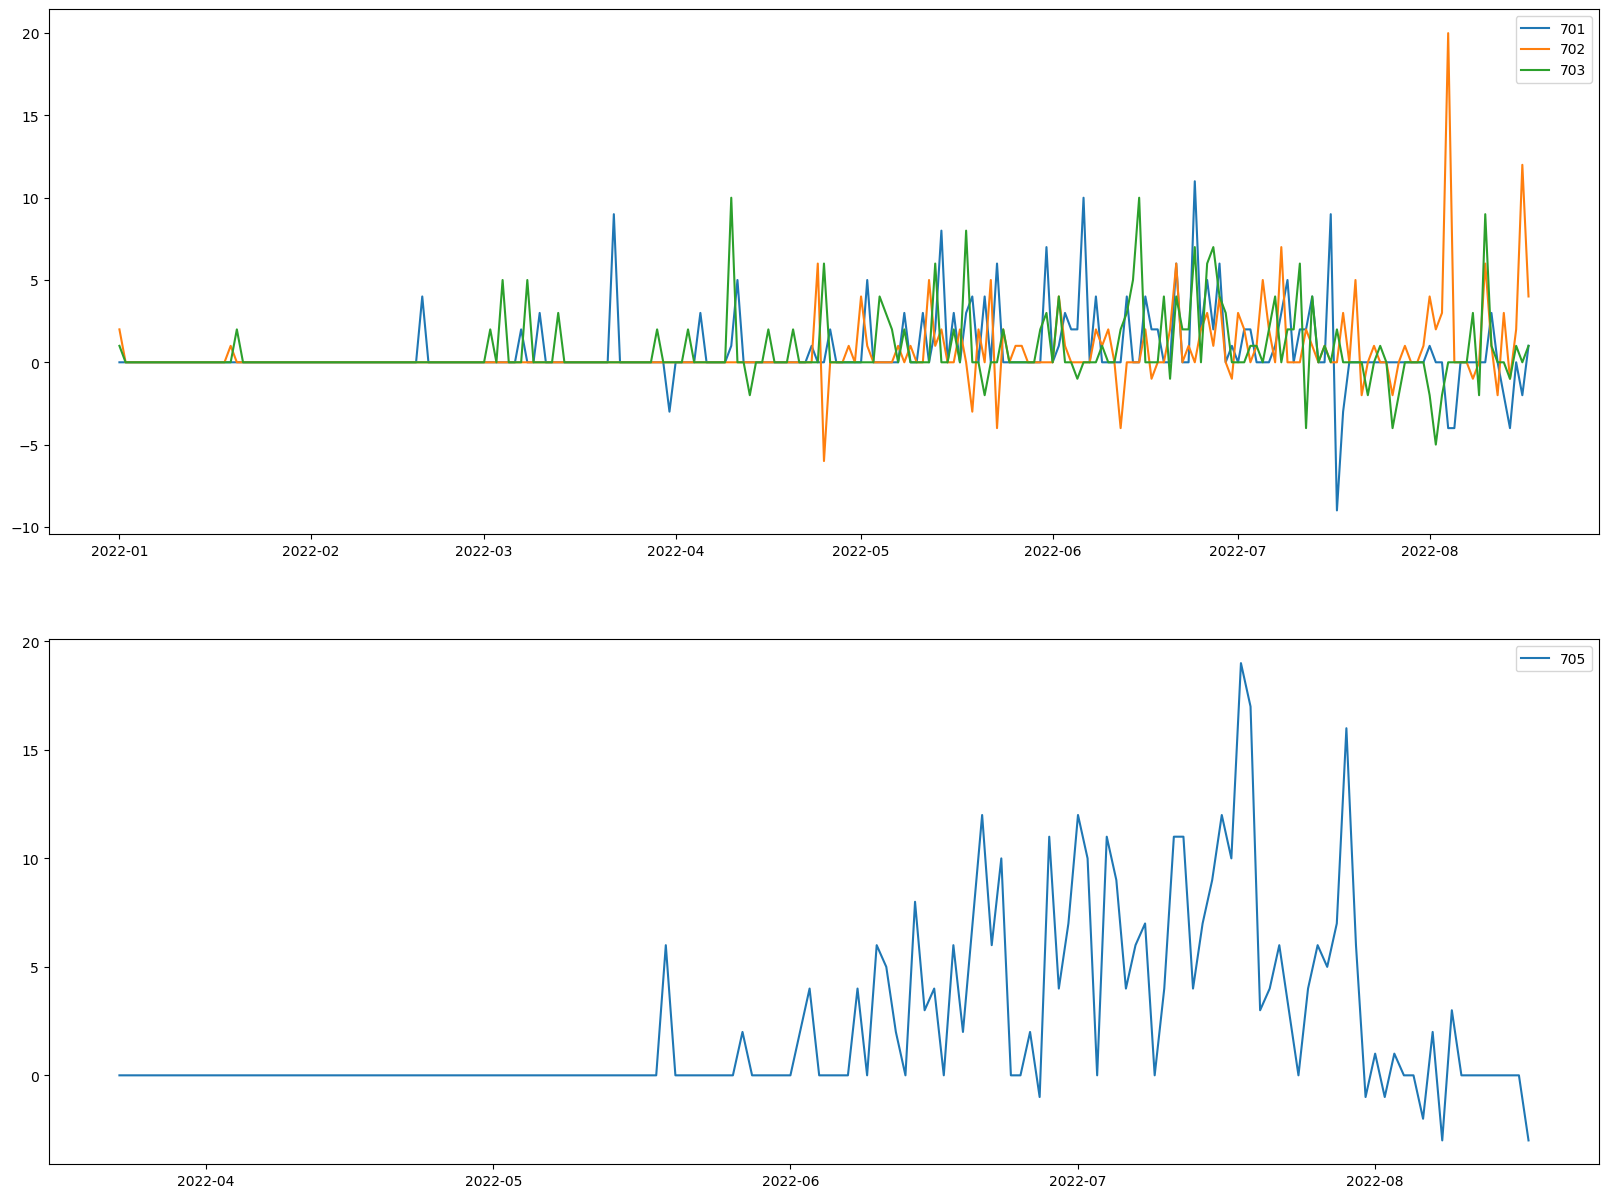

In [29]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,15))
ax1 = plt.subplot(2, 1, 1)
ax2 = plt.subplot(2, 1, 2)

#for flightno in sorted(flightno_list):
for flightno in [701, 702, 703, 705]:
    try:
        if flightno in flightno_189_list:
            ax1.plot(new_seats_df[(new_seats_df['flightno'] == flightno) & (new_seats_df['cabinclass'] == 'Y')]['issuedate']
                     , new_seats_df[(new_seats_df['flightno'] == flightno) & (new_seats_df['cabinclass'] == 'Y')]['sold_seats']
                     , label=str(flightno))
        else:
            ax2.plot(new_seats_df[(new_seats_df['flightno'] == flightno) & (new_seats_df['cabinclass'] == 'Y')]['issuedate']
                     , new_seats_df[(new_seats_df['flightno'] == flightno) & (new_seats_df['cabinclass'] == 'Y')]['sold_seats']
                     , label=str(flightno))
    except Exception as e:
        print(flightno)
        print(e)

plt.subplot(ax1)
plt.legend()
plt.subplot(ax2)
plt.legend()
plt.show()

## 3.4. 비행편 출항시간에 따른 판매건수 + 수익❌

- 쿠폰 데이터 셋에는 취소표에 대한 정보가 없음. (취소표의 금액과 건수를 포함할 수 없어 무의미한 정보)

## 3.5. 요일별 판매수 + 금액

- 요일에 따른 판매수 확인

In [149]:
weekday = ['Mon', 'Tue', 'Wed', 'Thr', 'Fri', 'Sat', 'Sun']

In [31]:
new_coupon_df['issueweekday'].value_counts().sort_index()

0     975
1    1212
2    1141
3    1151
4     742
5     745
6     703
Name: issueweekday, dtype: int64

In [32]:
list(new_coupon_df['issueweekday'].value_counts().sort_index())

[975, 1212, 1141, 1151, 742, 745, 703]

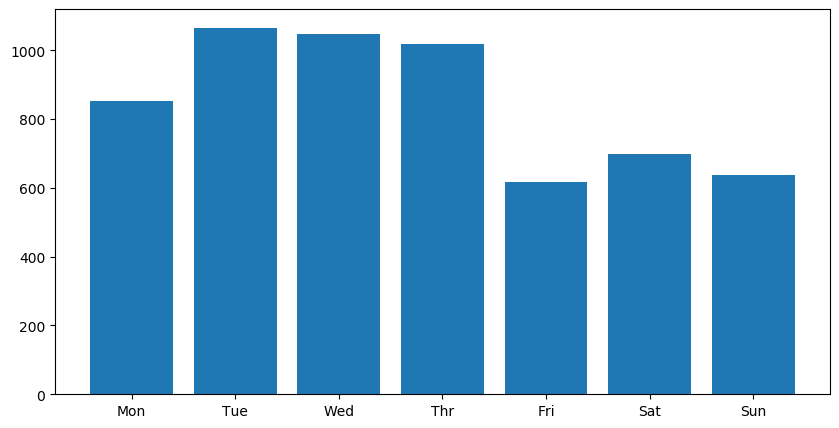

In [155]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))

#for flightno in sorted(flightno_list):
plt.bar(weekday, list(new_coupon_df[(new_coupon_df['fare']!=0) & (new_coupon_df['bookingclass'].isin(economic))]['issueweekday'].value_counts().sort_index()))

plt.show()

In [33]:
#new_coupon_df.groupby(['issueweekday'])['fare'].mean()
new_coupon_df[new_coupon_df['fare'] == 0].groupby(['issueweekday'])['fare'].count()

issueweekday
0    42
1    55
2    31
3    18
4    54
5     6
6     6
Name: fare, dtype: int64

In [157]:
list(new_coupon_df[(new_coupon_df['fare'] != 0) & (new_coupon_df['bookingclass'].isin(economic))].groupby(['issueweekday'])['fare'].mean())

[57319.28571428572,
 56124.99061913696,
 50908.38740458015,
 51526.715830875124,
 57590.25931928687,
 56829.42857142857,
 54223.57927786499]

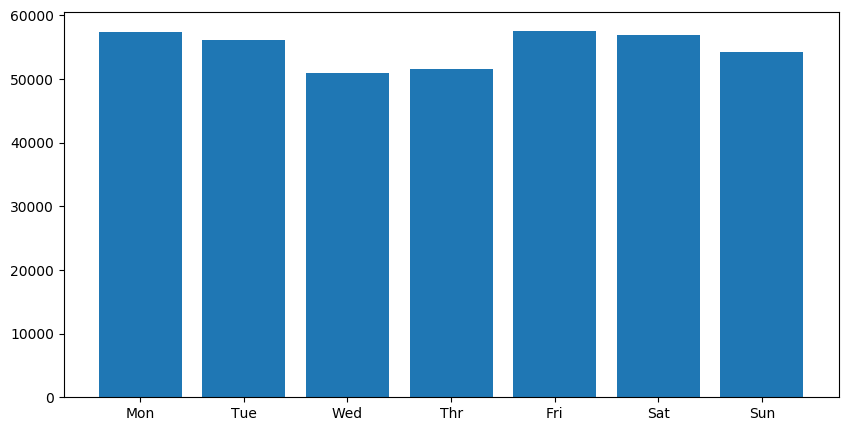

In [158]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))

#for flightno in sorted(flightno_list):
plt.bar(weekday, new_coupon_df[(new_coupon_df['fare'] != 0) & (new_coupon_df['bookingclass'].isin(economic))].groupby(['issueweekday'])['fare'].mean())

plt.show()

In [35]:
new_coupon_df.groupby(['issueweekday'])['fare'].mean()

issueweekday
0    53934.328205
1    52264.653465
2    49462.392638
3    49238.201564
4    50949.582210
5    55453.852349
6    52560.910384
Name: fare, dtype: float64

In [36]:
print(new_coupon_df[new_coupon_df['flightno'] == 701].groupby(['issueweekday'])['fare'].mean())
print(new_coupon_df[new_coupon_df['flightno'] == 701].groupby(['issueweekday'])['fare'].count())

issueweekday
0    37690.909091
1    40011.904762
2    43993.333333
3    50290.909091
4    38561.111111
5    55672.727273
6    49750.000000
Name: fare, dtype: float64
issueweekday
0    33
1    42
2    15
3    22
4    18
5    44
6    16
Name: fare, dtype: int64


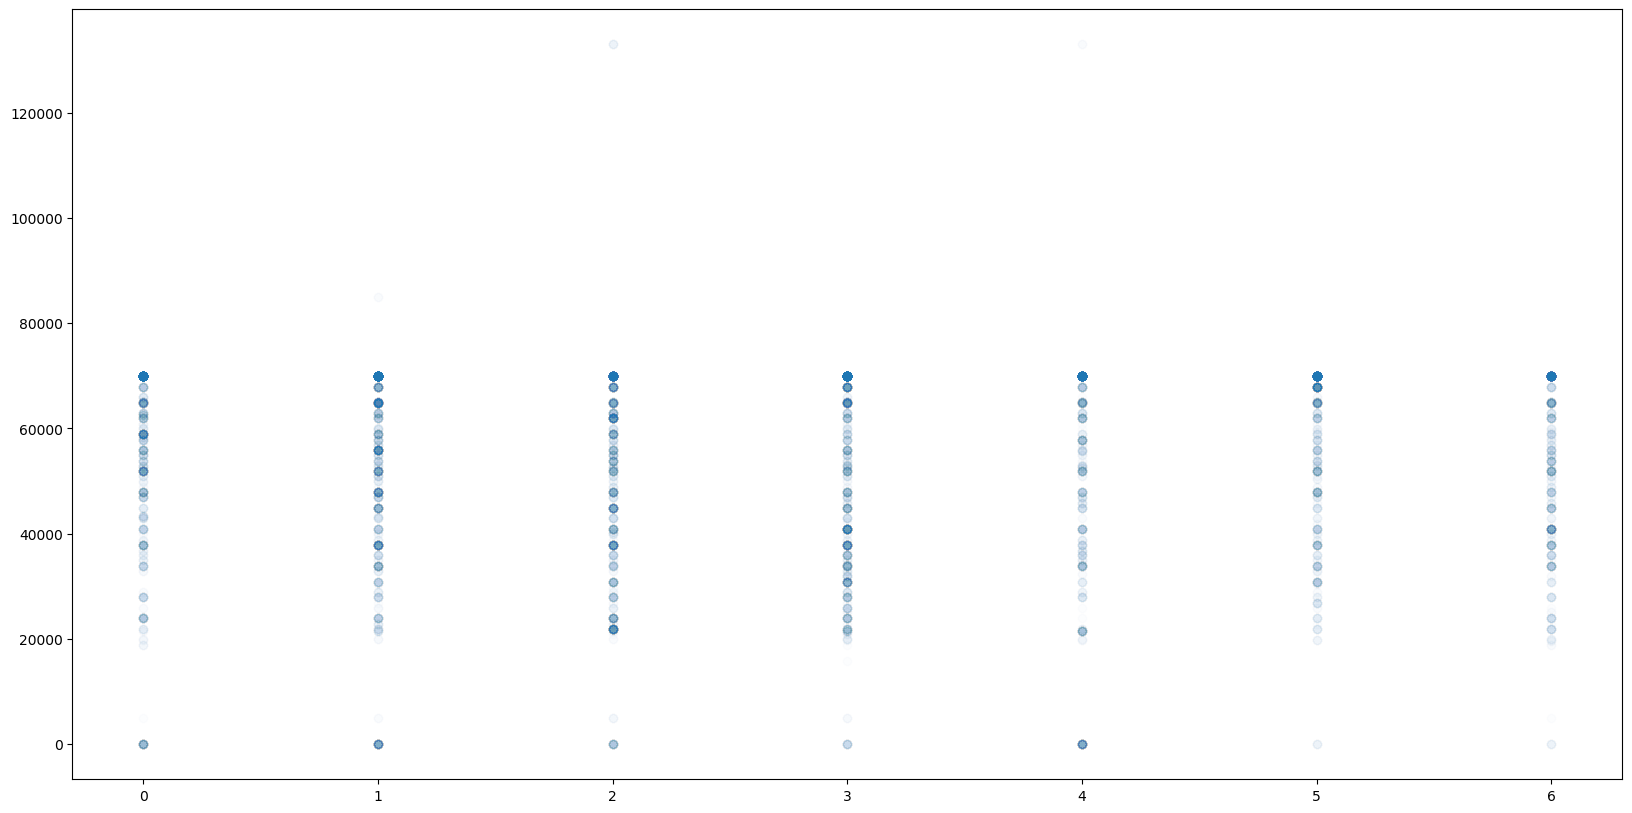

In [160]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))

#for flightno in sorted(flightno_list):
for flightno in [701]: # 단일항공편 확인시
    try:
        # x = new_coupon_df[new_coupon_df['flightno'] == flightno]['issueweekday']
        # y = new_coupon_df[new_coupon_df['flightno'] == flightno]['fare']
        x = new_coupon_df['issueweekday']
        y = new_coupon_df['fare']

        plt.scatter(x, y, alpha=0.01)
    except Exception as e:
        print(flightno)
        print(e)

plt.show()

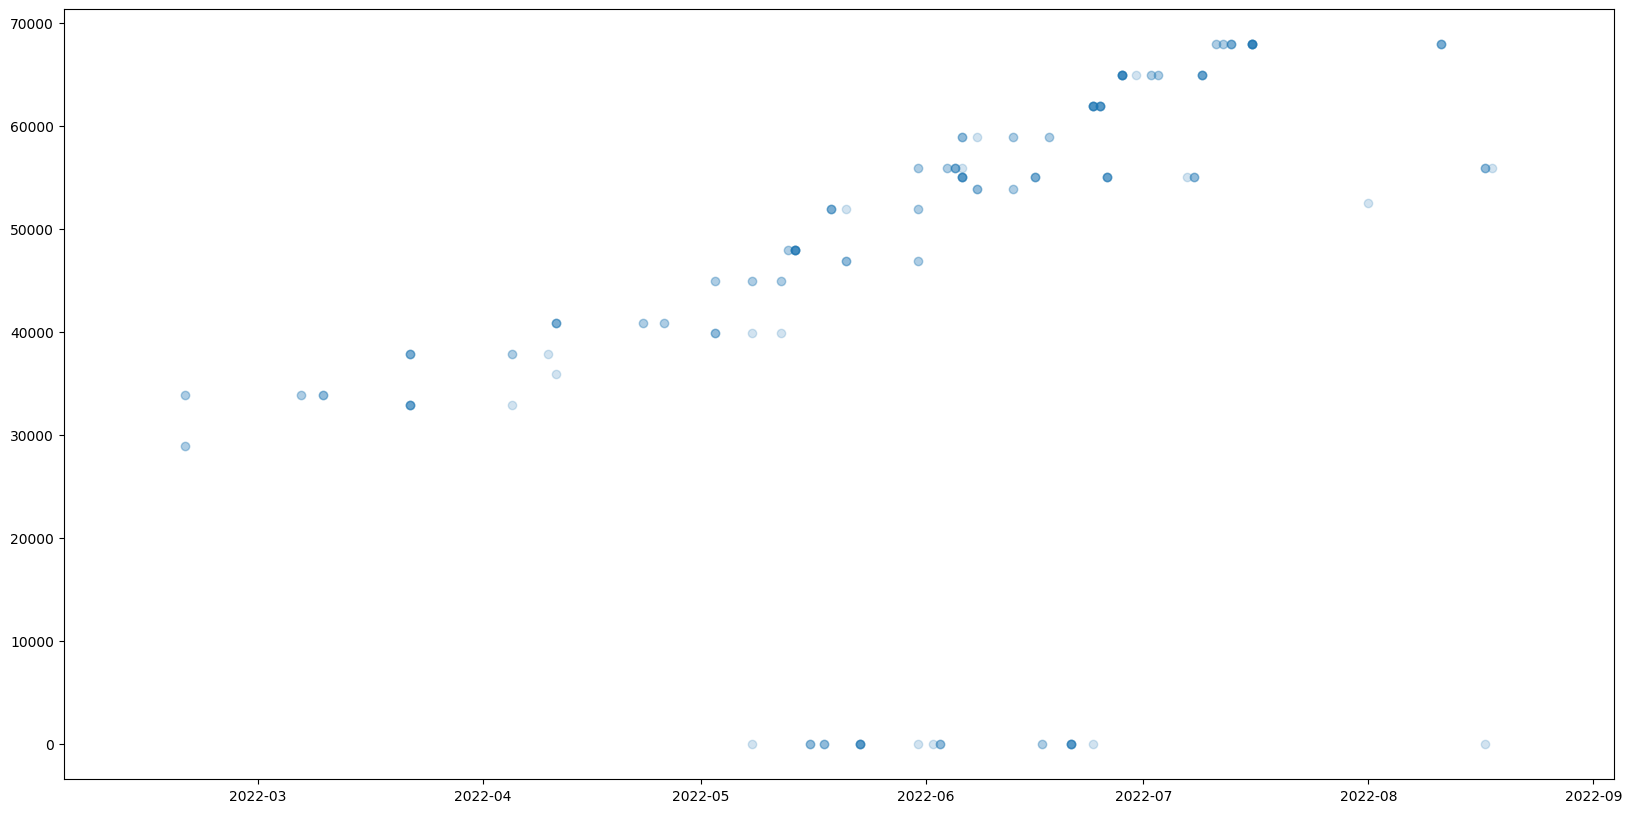

In [38]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))

#for flightno in sorted(flightno_list):
for flightno in [701]: # 단일항공편 확인시
    try:
        x = new_coupon_df[new_coupon_df['flightno'] == flightno]['issuedate']
        y = new_coupon_df[new_coupon_df['flightno'] == flightno]['fare']

        plt.scatter(x, y, alpha=0.2)
    except Exception as e:
        print(flightno)
        print(e)

plt.show()

## 3.6. 날씨 데이터 추가

In [39]:
weather_df = pd.read_csv(f's3://{bucket}/data/etc/OBS_ASOS_TIM_20220831155407.csv', encoding='CP949')

In [40]:
weather_df.head()

,지점,지점명,일시,기온(°C),기온 QC플래그,강수량(mm),강수량 QC플래그,풍속(m/s),풍속 QC플래그,풍향(16방위),...,최저운고(100m ),시정(10m),지면상태(지면상태코드),현상번호(국내식),지면온도(°C),지면온도 QC플래그,5cm 지중온도(°C),10cm 지중온도(°C),20cm 지중온도(°C),30cm 지중온도(°C)
0,108,서울,2022-01-01 01:00,-9.2,NaN,NaN,NaN,1.8,NaN,270,...,NaN,2000,NaN,NaN,-7.2,NaN,-1.1,-1.1,-0.2,1.0
1,108,서울,2022-01-01 02:00,-9.5,NaN,NaN,NaN,1.2,NaN,270,...,NaN,2000,NaN,NaN,-7.5,NaN,-1.3,-1.2,-0.2,1.0
2,108,서울,2022-01-01 03:00,-9.3,NaN,NaN,NaN,1.4,NaN,290,...,NaN,2000,NaN,NaN,-7.6,NaN,-1.4,-1.2,-0.2,1.0
3,108,서울,2022-01-01 04:00,-9.6,NaN,NaN,NaN,1.7,NaN,340,...,NaN,2000,NaN,NaN,-7.6,NaN,-1.4,-1.3,-0.3,1.0
4,108,서울,2022-01-01 05:00,-9.7,NaN,NaN,NaN,0.8,NaN,270,...,NaN,2000,NaN,NaN,-7.7,NaN,-1.5,-1.4,-0.3,1.0


In [41]:
weather_df['강수량(mm)'].fillna(0, inplace=True)

In [42]:
weather_df['일시'] = pd.to_datetime(weather_df['일시'])

In [43]:
weather_df['date'] = weather_df['일시'].dt.date

In [44]:
date_list = list(weather_df['date'].unique())
temp_min = list(weather_df.groupby(['date'])['기온(°C)'].min())
temp_max = list(weather_df.groupby(['date'])['기온(°C)'].max())
temp_avg = list(weather_df.groupby(['date'])['기온(°C)'].mean())
precipitation_total = list(weather_df.groupby(['date'])['강수량(mm)'].sum())
cloudiness = list(weather_df.groupby(['date'])['전운량(10분위)'].mean())

new_weather_df = pd.DataFrame({
                    'date': date_list,
                    'temp_min': temp_min,
                    'temp_max': temp_max,
                    'temp_avg': temp_avg,
                    'precipitation_total': precipitation_total,
                    'cloudiness': cloudiness
                })


In [45]:
new_weather_df['date'] = pd.to_datetime(new_weather_df['date'])

In [46]:
new_coupon_df = pd.merge(new_coupon_df, new_weather_df, left_on=['issuedate'], right_on=['date'], how='left')

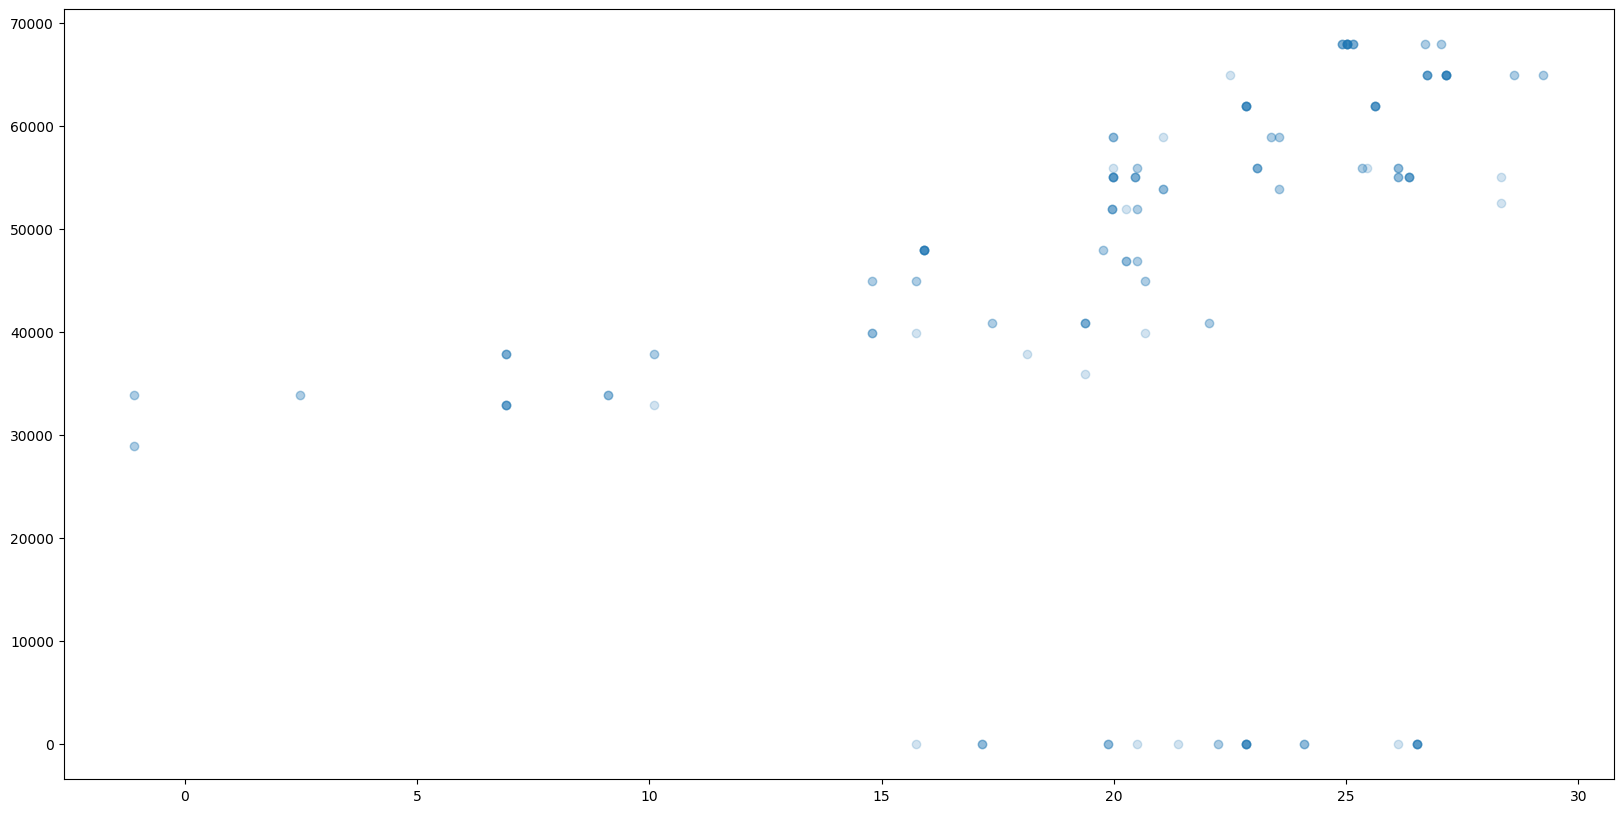

In [47]:
# 날씨는 기온으로 판단할 수 없다.
# 기상청 데이터 기준 운량 -> 맑음(0~2), 구름조금(3~5), 구름많음(6~8), 흐림(9~10이상) 

plt.figure(figsize=(20,10))

#for flightno in sorted(flightno_list):
for flightno in [701]: # 단일항공편 확인시
    try:
        x = new_coupon_df[new_coupon_df['flightno'] == flightno]['temp_avg']
        y = new_coupon_df[new_coupon_df['flightno'] == flightno]['fare']

        plt.scatter(x, y, alpha=0.2)
    except Exception as e:
        print(flightno)
        print(e)

plt.show()

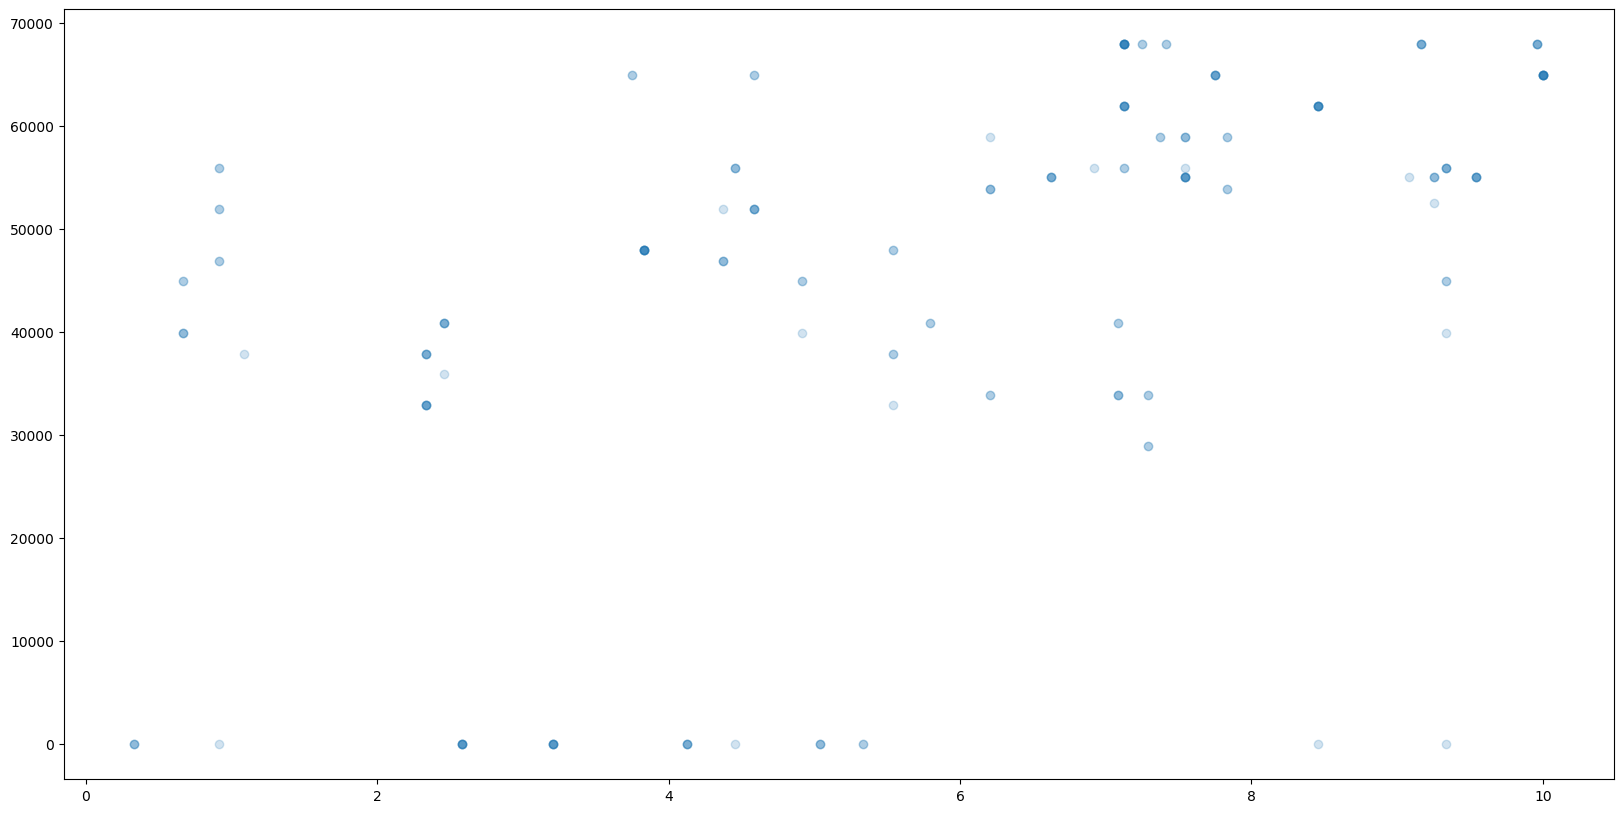

In [48]:
# 날씨는 기온으로 판단할 수 없다.
# 기상청 데이터 기준 운량 -> 맑음(0~2), 구름조금(3~5), 구름많음(6~8), 흐림(9~10이상) 

plt.figure(figsize=(20,10))

#for flightno in sorted(flightno_list):
for flightno in [701]: # 단일항공편 확인시
    try:
        x = new_coupon_df[new_coupon_df['flightno'] == flightno]['cloudiness']
        y = new_coupon_df[new_coupon_df['flightno'] == flightno]['fare']

        plt.scatter(x, y, alpha=0.2)
    except Exception as e:
        print(flightno)
        print(e)

plt.show()

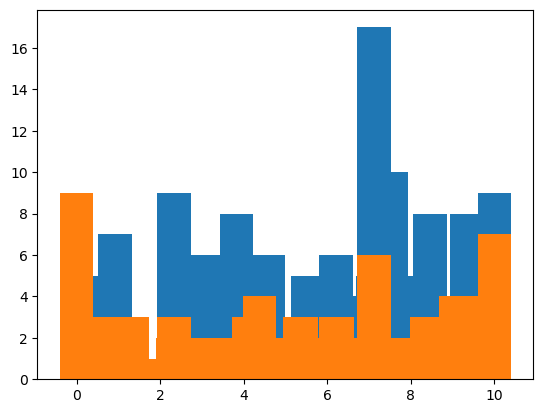

In [49]:
#plt.countplot(new_coupon_df[new_coupon_df['flightno'] == flightno]['cloudiness'])

#list(new_coupon_df[new_coupon_df['flightno'] == flightno]['cloudiness'].value_counts())
plt.bar(new_coupon_df[new_coupon_df['flightno'] == flightno]['cloudiness'].value_counts().sort_index().index
       , list(new_coupon_df[new_coupon_df['flightno'] == flightno]['cloudiness'].value_counts().sort_index()))

plt.bar(new_weather_df['cloudiness'].value_counts().sort_index().index
       , list(new_weather_df['cloudiness'].value_counts().sort_index()))

plt.show()

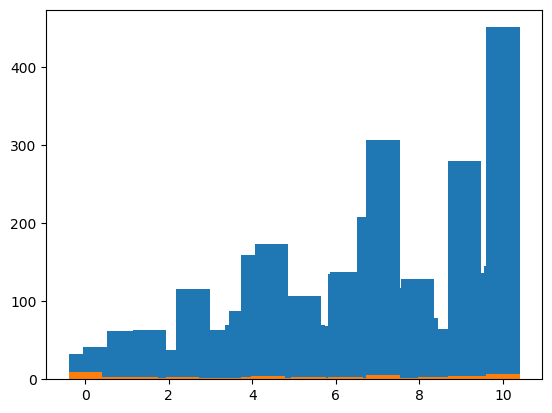

In [50]:
#plt.countplot(new_coupon_df[new_coupon_df['flightno'] == flightno]['cloudiness'])

#list(new_coupon_df[new_coupon_df['flightno'] == flightno]['cloudiness'].value_counts())
plt.bar(new_coupon_df['cloudiness'].value_counts().sort_index().index
       , list(new_coupon_df['cloudiness'].value_counts().sort_index()))

plt.bar(new_weather_df['cloudiness'].value_counts().sort_index().index
       , list(new_weather_df['cloudiness'].value_counts().sort_index()))

plt.show()

# 3.7. fare값 천단위로 변형하기

In [51]:
new_coupon_df['fare_1000'] = new_coupon_df['fare'] // 1000 * 1000

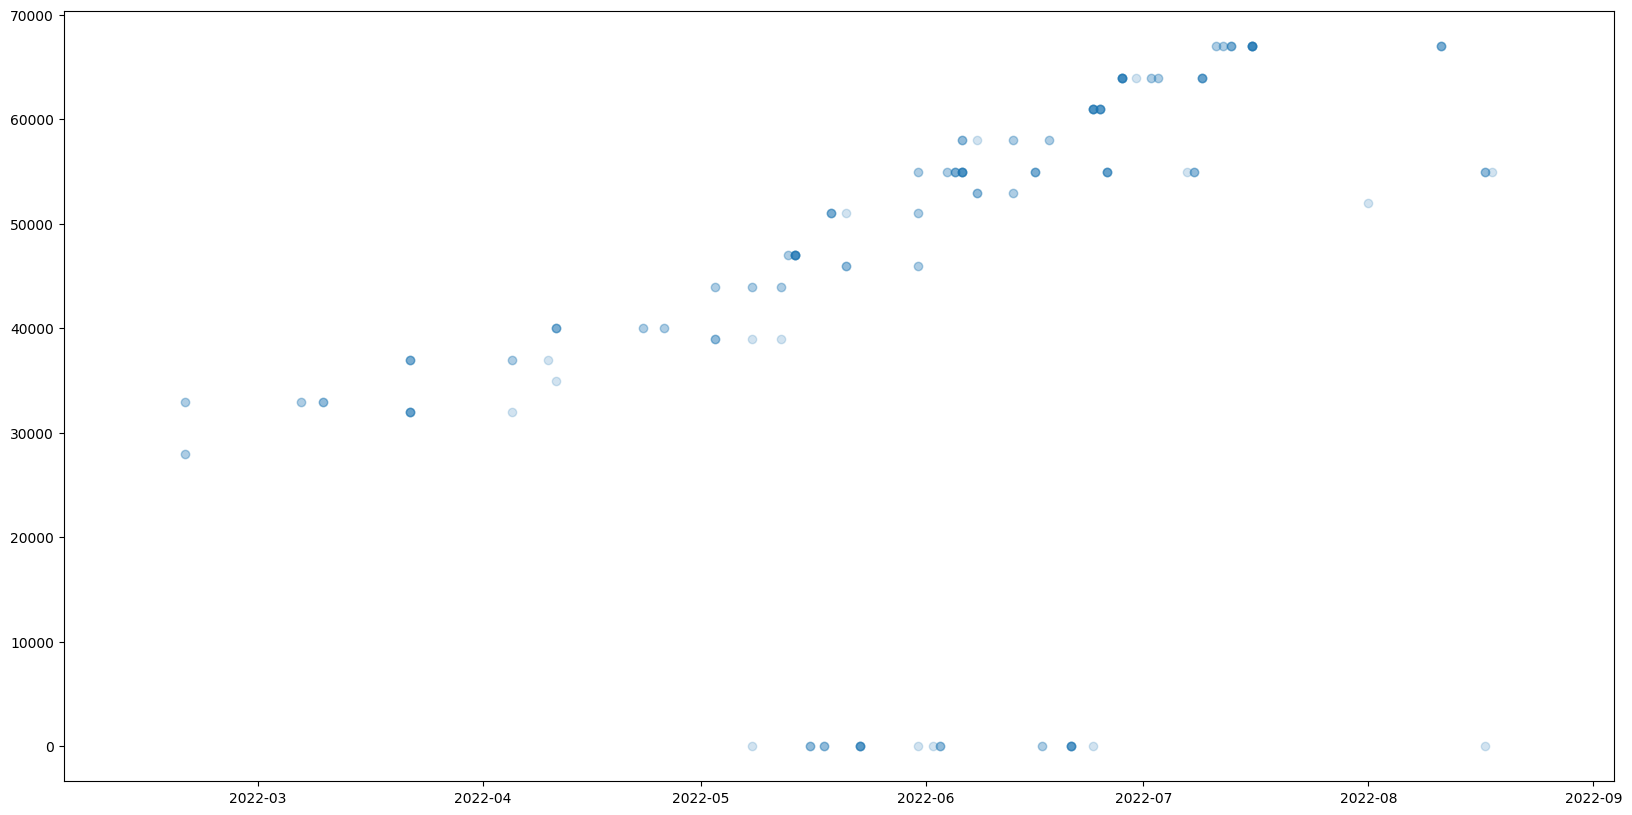

In [52]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))

#for flightno in sorted(flightno_list):
for flightno in [701]: # 단일항공편 확인시
    try:
        x = new_coupon_df[new_coupon_df['flightno'] == flightno]['issuedate']
        y = new_coupon_df[new_coupon_df['flightno'] == flightno]['fare_1000']

        plt.scatter(x, y, alpha=0.2)
    except Exception as e:
        print(flightno)
        print(e)

plt.show()

# 4. 테스트 모델링

- 현재 데이터는 시계열 보다 회귀문제로 보는 것이 맞다고 생각됨.
- input으로 넣을 데이터를 선정하고, 몇가지 회귀 모델 테스트를 진행

## 4.1. 데이터 정제

- 학습을 위해 불필요한 데이터나 이상치 데이터를 제거
- feature engineering을 통한 컬럼 추가

In [53]:
# 새로 만든 당일 판매 건수 count 컬럼을 new_coupon_df에 추가
new_coupon_df = pd.merge(new_coupon_df, new_seats_df[['flightno', 'issuedate', 'cabinclass', 'sold_seats']], on=['flightno', 'issuedate', 'cabinclass'], how='left')

In [54]:
new_coupon_df.head()

,ticketno,issuedate,cpnno,startseg,endseg,carrier,bookingclass,flightdate,flightno,fare,...,total_sold_seats,issueweekday,date,temp_min,temp_max,temp_avg,precipitation_total,cloudiness,fare_1000,sold_seats
0,7222156209406,2022-04-20,1,GMP,CJU,TW,T,2022-08-22,707,58900,...,91.0,2,2022-04-20,9.8,22.0,15.6500,0.0,0.000000,58000,4.0
1,7222156211479,2022-04-20,2,CJU,GMP,TW,P,2022-08-22,740,61900,...,44.0,2,2022-04-20,9.8,22.0,15.6500,0.0,0.000000,61000,6.0
2,7222156211481,2022-04-20,2,CJU,GMP,TW,P,2022-08-22,740,61900,...,44.0,2,2022-04-20,9.8,22.0,15.6500,0.0,0.000000,61000,6.0
3,7222403540697,2022-04-21,2,CJU,GMP,TW,M,2022-08-22,710,50900,...,8.0,3,2022-04-21,9.7,22.5,16.0625,0.0,4.291667,50000,4.0
4,7222403540698,2022-04-21,2,CJU,GMP,TW,M,2022-08-22,710,50900,...,8.0,3,2022-04-21,9.7,22.5,16.0625,0.0,4.291667,50000,4.0


In [55]:
# remaindate 124 days -> 124 로 변경
new_coupon_df['remaindate'] = new_coupon_df['remaindate'].dt.days

In [56]:
# led_departure_date_time 시, 분 분리하기
#new_coupon_df['departure_hour'] = new_coupon_df['led_departure_date_time'].dt.time
new_coupon_df['departure_hour'] = new_coupon_df['leg_departure_date_time'].dt.hour
new_coupon_df['departure_minute'] = new_coupon_df['leg_departure_date_time'].dt.minute
new_coupon_df['departure_time_format_min'] = new_coupon_df['departure_hour'] * 60 + new_coupon_df['departure_minute']

In [57]:
new_coupon_df.head()

,ticketno,issuedate,cpnno,startseg,endseg,carrier,bookingclass,flightdate,flightno,fare,...,temp_min,temp_max,temp_avg,precipitation_total,cloudiness,fare_1000,sold_seats,departure_hour,departure_minute,departure_time_format_min
0,7222156209406,2022-04-20,1,GMP,CJU,TW,T,2022-08-22,707,58900,...,9.8,22.0,15.6500,0.0,0.000000,58000,4.0,9,45,585
1,7222156211479,2022-04-20,2,CJU,GMP,TW,P,2022-08-22,740,61900,...,9.8,22.0,15.6500,0.0,0.000000,61000,6.0,18,10,1090
2,7222156211481,2022-04-20,2,CJU,GMP,TW,P,2022-08-22,740,61900,...,9.8,22.0,15.6500,0.0,0.000000,61000,6.0,18,10,1090
3,7222403540697,2022-04-21,2,CJU,GMP,TW,M,2022-08-22,710,50900,...,9.7,22.5,16.0625,0.0,4.291667,50000,4.0,11,5,665
4,7222403540698,2022-04-21,2,CJU,GMP,TW,M,2022-08-22,710,50900,...,9.7,22.5,16.0625,0.0,4.291667,50000,4.0,11,5,665


In [58]:
df = new_coupon_df.copy()
print('=' * 100)
print(f'최초: {df.shape}')

# 비즈니스석 제외
print('=' * 100)
df = df[df['cabinclass'] == 'Y']
print(f'이코노미석 추출: {df.shape}')

# bookingclass 특수값 제거
print('=' * 100)
business = ['F', 'C', 'R', 'CC', 'CG', 'C1', 'C2'] # 이코너미만 체크할 것
economic = ['Y', 'Z', 'W', 'V', 'T', 'S', 'P', 'O', 'N', 'M', 'L', 'I', 'H', 'J', 'E', 'D', 'B']
event = ['A', 'BB', 'BL', 'UU', 'U',  'G', 'Q', 'R', 'X'] # 정상가가 아님 고려대상 X

df = df[df['bookingclass'].isin(economic)]
print(f'booking class 특수값 제거: {df.shape}')


# 이코노미, 특수값 제거 후에도 0원 짜리가 존재함
print('=' * 100)
print(f"=> min: {min(df['fare'])}, max: {max(df['fare'])}")
print(f"=> 일반임에도 0원 짜리인 건수: {len(df[df['fare'] == 0])}")
#제거
df = df[df['fare'] != 0]
print(f'0원짜리 제거: {df.shape}')

# 테이블 merge 했음에 공백인 데이터
print('=' * 100)
print('=> 테이블 merge 하면서 nan 값이 생긴 컬럼체크')
print(df.isna().sum())
# total_sold_seats, sold_seats
# 예약데이터와 쿠폰데이터의 시간 범위 차이가 존재함.
print(df[df['total_sold_seats'].isna()]['issuedate'].unique())
df = df.dropna()
print(f'NaN 값 제거(예약데이터에 날짜 포함되지 않은 값 제거): {df.shape}')
print('=' * 100)

최초: (6669, 32)
이코노미석 추출: (6657, 32)
booking class 특수값 제거: (5985, 32)
=> min: 0, max: 85000
=> 일반임에도 0원 짜리인 건수: 46
0원짜리 제거: (5939, 32)
=> 테이블 merge 하면서 nan 값이 생긴 컬럼체크
ticketno                       0
issuedate                      0
cpnno                          0
startseg                       0
endseg                         0
carrier                        0
bookingclass                   0
flightdate                     0
flightno                       0
fare                           0
farevat                        0
pfc                            0
fsc                            0
fscvat                         0
cabinclass                     0
remaindate                     0
cabin_authorised_cap           0
leg_departure_date_time        0
leg_arrival_date_time          0
total_sold_seats             184
issueweekday                   0
date                           8
temp_min                       8
temp_max                       8
temp_avg                       8
precipita

## 4.2. 학습용 input, output 값 만들기

In [109]:
target_y = ['fare']
feature_x = ['departure_hour', 'departure_minute', 'departure_time_format_min'
             , 'sold_seats', 'total_sold_seats', 'remaindate']

In [110]:
df['remaindate'] = df['remaindate'].astype('float')
df['departure_hour'] = df['departure_hour'].astype('float')
df['departure_minute'] = df['departure_minute'].astype('float')
df['departure_time_format_min'] = df['departure_time_format_min'].astype('float')

In [111]:
gimpo = df[df['startseg'] == 'GMP']
jeju = df[df['startseg'] == 'CJU']

In [112]:
print(gimpo.shape)
print(jeju.shape)

(2788, 32)
(2967, 32)


In [113]:
gimpo_x = gimpo[feature_x]
gimpo_y = gimpo[target_y]

gimpo_x.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2788 entries, 0 to 6637
Data columns (total 6 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   departure_hour             2788 non-null   float64
 1   departure_minute           2788 non-null   float64
 2   departure_time_format_min  2788 non-null   float64
 3   sold_seats                 2788 non-null   float64
 4   total_sold_seats           2788 non-null   float64
 5   remaindate                 2788 non-null   float64
dtypes: float64(6)
memory usage: 152.5 KB


## 4.3. 모델 학습

In [114]:
## Train/Test Split
from sklearn.model_selection import train_test_split

train_x, test_x, train_y, test_y = train_test_split(gimpo_x, gimpo_y, test_size=0.2, random_state=42)

In [115]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(max_depth=10, random_state=42)
model.fit(train_x, train_y)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=10, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [116]:
## Train 점수
print(model.score(train_x, train_y))
## Test 점수
print(model.score(test_x, test_y))

0.9834859874869375
0.9753403558924839


In [67]:
## RMSE 값 생성
from sklearn.metrics import mean_squared_error

## Train RMSE
pred = model.predict(train_x)
RMSE = mean_squared_error(train_y, pred)**0.5
print(RMSE)

## Test RMSE
pred = model.predict(test_x)
RMSE = mean_squared_error(test_y, pred)**0.5
print(RMSE)

2133.8820978973195
2618.1119442673385


In [68]:
import numpy as np

feature_importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)

for i in range(len(feature_x)):
    print(f"{feature_x[i]}: {feature_importances[i]}")

departure_hour: 0.3280452359698354
departure_minute: 0.021102543518425162
departure_time_format_min: 0.3421630415060493
sold_seats: 0.013179399031447676
total_sold_seats: 0.21355963324819247
remaindate: 0.0819501467260498


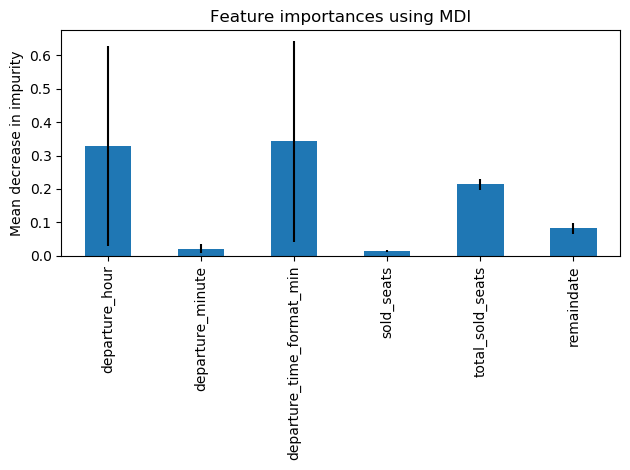

In [69]:
forest_importances = pd.Series(feature_importances, index=feature_x)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

plt.show()

## 4.4. 예측 분포 시각화

In [70]:
temp_result = list(model.predict(train_x))
temp_result.extend(list(model.predict(test_x)))

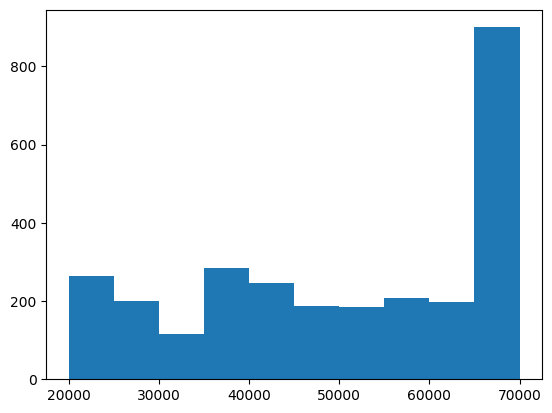

In [71]:
plt.hist(temp_result)
plt.show()

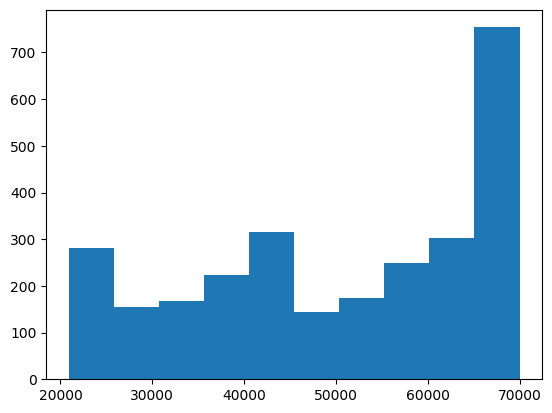

In [72]:
plt.hist(df[(df['fare'] > 20000) & (df['startseg'] == 'GMP')]['fare'])
plt.show()

## 4.5. 모델 학습 - 항공편 1개 test로 빼서 진행

In [117]:
## Train/Test Split
from sklearn.model_selection import train_test_split

test_flightno = 701

gimpo2 = df[(df['startseg'] == 'GMP') & (df['flightno'] != test_flightno)]
jeju2 = df[(df['startseg'] == 'CJU') & (df['flightno'] != test_flightno)]

gimpo2_x = gimpo2[feature_x]
gimpo2_y = gimpo2[target_y]

train2_x, test2_x, train2_y, test2_y = train_test_split(gimpo2_x, gimpo2_y, test_size=0.2, random_state=42)

In [118]:
from sklearn.ensemble import RandomForestRegressor
model2 = RandomForestRegressor(max_depth=10, random_state=42)
model2.fit(train2_x, train2_y)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=10, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [119]:
## Train 점수
print(model2.score(train2_x, train2_y))
## Test 점수
print(model2.score(test2_x, test2_y))

0.9840203918880603
0.9757902356295866


In [120]:
## RMSE 값 생성
from sklearn.metrics import mean_squared_error, mean_absolute_error

## Train RMSE
pred = model2.predict(train2_x)
RMSE = mean_squared_error(train2_y, pred)**0.5
MAE = mean_absolute_error(train2_y, pred)**0.5
print(MAE)
print(RMSE)
print('=' * 80)
## Test RMSE
pred = model2.predict(test2_x)
RMSE = mean_squared_error(test2_y, pred)**0.5
MAE = mean_absolute_error(test2_y, pred)**0.5
print(MAE)
print(RMSE)

33.19627251822144
2121.763408678981
37.56259918714682
2639.7264607501347


In [121]:
import numpy as np

feature_importances = model2.feature_importances_
std = np.std([tree.feature_importances_ for tree in model2.estimators_], axis=0)

for i in range(len(feature_x)):
    print(f"{feature_x[i]}: {feature_importances[i]}")

departure_hour: 0.3451930127484362
departure_minute: 0.005305810630034264
departure_time_format_min: 0.35808142673855503
sold_seats: 0.016133670554087775
total_sold_seats: 0.17524292082368093
remaindate: 0.10004315850520576


## 4.6. 예측 분포 시각화

In [122]:
gimpo_test = df[(df['startseg'] == 'GMP') & (df['flightno'] == test_flightno)]

In [123]:
gimpo_test_x = gimpo_test[feature_x]
gimpo_test_y = gimpo_test[target_y]

pred_test = list(model2.predict(gimpo_test_x))

In [124]:
## RMSE 값 생성
from sklearn.metrics import mean_squared_error, mean_absolute_error

## Test RMSE
RMSE = mean_squared_error(gimpo_test_y, pred_test)**0.5
MAE = mean_absolute_error(gimpo_test_y, pred_test)**0.5
print(RMSE)
print(MAE)

4360.382936034435
57.795276914997494


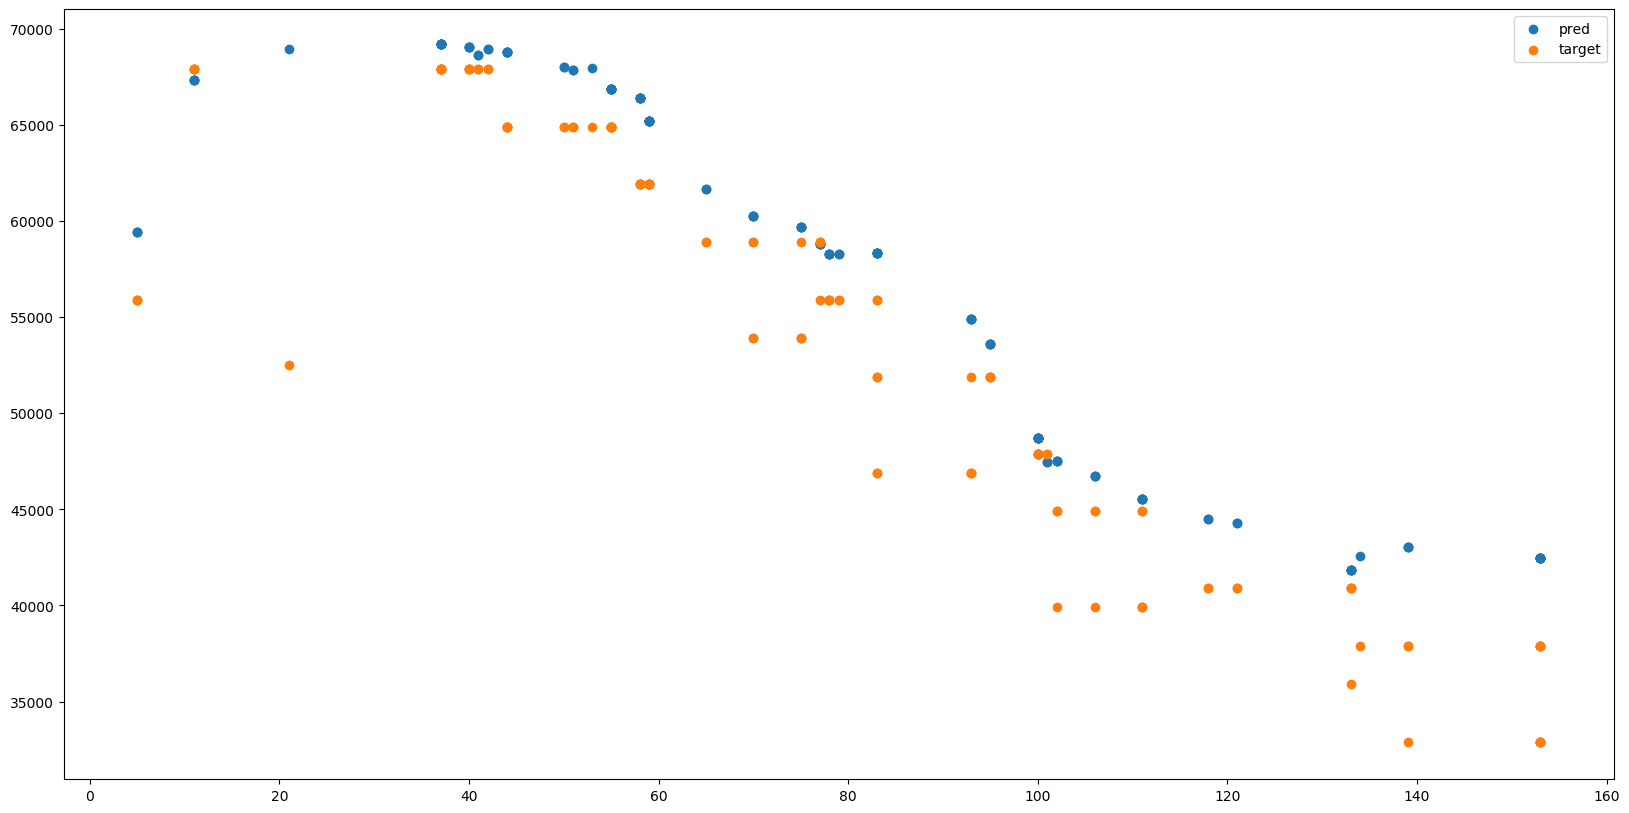

In [125]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))

plt.scatter(gimpo_test_x['remaindate'], pred_test, label='pred')
plt.scatter(gimpo_test_x['remaindate'], gimpo_test_y, label='target')

plt.legend()
plt.show()

In [59]:
new_seats_df.head()

,flightno,issuedate,cabinclass,total_sold_seats,cabin_authorised_cap,sold_seats
0,701,2022-01-01,Y,0,189.0,0.0
1,701,2022-01-02,Y,0,189.0,0.0
2,701,2022-01-03,Y,0,189.0,0.0
3,701,2022-01-04,Y,0,189.0,0.0
4,701,2022-01-05,Y,0,189.0,0.0


In [60]:
new_coupon_df.head()

,ticketno,issuedate,cpnno,startseg,endseg,carrier,bookingclass,flightdate,flightno,fare,...,temp_min,temp_max,temp_avg,precipitation_total,cloudiness,fare_1000,sold_seats,departure_hour,departure_minute,departure_time_format_min
0,7222156209406,2022-04-20,1,GMP,CJU,TW,T,2022-08-22,707,58900,...,9.8,22.0,15.6500,0.0,0.000000,58000,4.0,9,45,585
1,7222156211479,2022-04-20,2,CJU,GMP,TW,P,2022-08-22,740,61900,...,9.8,22.0,15.6500,0.0,0.000000,61000,6.0,18,10,1090
2,7222156211481,2022-04-20,2,CJU,GMP,TW,P,2022-08-22,740,61900,...,9.8,22.0,15.6500,0.0,0.000000,61000,6.0,18,10,1090
3,7222403540697,2022-04-21,2,CJU,GMP,TW,M,2022-08-22,710,50900,...,9.7,22.5,16.0625,0.0,4.291667,50000,4.0,11,5,665
4,7222403540698,2022-04-21,2,CJU,GMP,TW,M,2022-08-22,710,50900,...,9.7,22.5,16.0625,0.0,4.291667,50000,4.0,11,5,665


In [61]:
new_coupon_df.groupby(['issuedate', 'flightno'])['sold_seats']

In [68]:
new_coupon_df[new_coupon_df['flightno'] == 738].groupby(['issuedate', 'flightno'])['ticketno'].count()

issuedate   flightno
2022-04-23  738          5
2022-05-02  738          5
2022-05-11  738          1
2022-05-26  738          3
2022-05-29  738          1
2022-05-31  738          3
2022-06-01  738          1
2022-06-02  738          4
2022-06-03  738          5
2022-06-05  738          1
2022-06-07  738          2
2022-06-08  738          3
2022-06-12  738          1
2022-06-13  738          1
2022-06-14  738          1
2022-06-20  738          7
2022-06-21  738          3
2022-06-24  738          5
2022-06-25  738          3
2022-06-27  738          1
2022-06-28  738          1
2022-07-01  738          1
2022-07-02  738          3
2022-07-03  738          1
2022-07-05  738          3
2022-07-06  738          1
2022-07-08  738          1
2022-07-09  738          1
2022-07-13  738          4
2022-07-16  738          2
2022-07-17  738          3
2022-07-20  738          1
2022-07-23  738          2
2022-08-01  738          2
2022-08-02  738          4
2022-08-03  738          4
2022-08

In [177]:
new_seats_df[(new_seats_df['flightno'] == 738) & (new_seats_df['sold_seats'] != 0)]

,flightno,issuedate,cabinclass,total_sold_seats,cabin_authorised_cap,sold_seats
5983,738,2022-04-23,Y,5,189.0,5.0
5992,738,2022-05-02,Y,10,189.0,5.0
6001,738,2022-05-11,Y,11,189.0,1.0
6016,738,2022-05-26,Y,14,189.0,3.0
6019,738,2022-05-29,Y,15,189.0,1.0
6021,738,2022-05-31,Y,18,189.0,3.0
6022,738,2022-06-01,Y,19,189.0,1.0
6023,738,2022-06-02,Y,23,189.0,4.0
6024,738,2022-06-03,Y,28,189.0,5.0
6026,738,2022-06-05,Y,29,189.0,1.0


In [174]:
new_coupon_df2 = pd.DataFrame({'coupon_sold_seats' : new_coupon_df[new_coupon_df['flightno'] == 738].groupby(['issuedate', 'flightno'])['ticketno'].count()}).reset_index()
# new_coupon_df[new_coupon_df['flightno'] == 738].groupby(['issuedate', 'flightno'])['ticketno'].count()
new_coupon_df2.head()

,issuedate,flightno,coupon_sold_seats
0,2022-04-23,738,5
1,2022-05-02,738,5
2,2022-05-11,738,1
3,2022-05-26,738,3
4,2022-05-29,738,1


In [175]:
new_seats_df2 = new_seats_df[(new_seats_df['flightno'] == 738) & (new_seats_df['sold_seats'] != 0)]

In [178]:
pd.merge(new_coupon_df2, new_seats_df2, on=['issuedate'], how='outer').sort_values('issuedate')

,issuedate,flightno_x,coupon_sold_seats,flightno_y,cabinclass,total_sold_seats,cabin_authorised_cap,sold_seats
0,2022-04-23,738.0,5.0,738.0,Y,5.0,189.0,5.0
1,2022-05-02,738.0,5.0,738.0,Y,10.0,189.0,5.0
2,2022-05-11,738.0,1.0,738.0,Y,11.0,189.0,1.0
3,2022-05-26,738.0,3.0,738.0,Y,14.0,189.0,3.0
4,2022-05-29,738.0,1.0,738.0,Y,15.0,189.0,1.0
5,2022-05-31,738.0,3.0,738.0,Y,18.0,189.0,3.0
6,2022-06-01,738.0,1.0,738.0,Y,19.0,189.0,1.0
7,2022-06-02,738.0,4.0,738.0,Y,23.0,189.0,4.0
8,2022-06-03,738.0,5.0,738.0,Y,28.0,189.0,5.0
9,2022-06-05,738.0,1.0,738.0,Y,29.0,189.0,1.0


In [71]:
new_seats_df[(new_seats_df['flightno'] == 738) & (new_seats_df['sold_seats'] != 0)]

,flightno,issuedate,cabinclass,total_sold_seats,cabin_authorised_cap,sold_seats
5983,738,2022-04-23,Y,5,189.0,5.0
5992,738,2022-05-02,Y,10,189.0,5.0
6001,738,2022-05-11,Y,11,189.0,1.0
6016,738,2022-05-26,Y,14,189.0,3.0
6019,738,2022-05-29,Y,15,189.0,1.0
6021,738,2022-05-31,Y,18,189.0,3.0
6022,738,2022-06-01,Y,19,189.0,1.0
6023,738,2022-06-02,Y,23,189.0,4.0
6024,738,2022-06-03,Y,28,189.0,5.0
6026,738,2022-06-05,Y,29,189.0,1.0


In [72]:
len(new_coupon_df)

6669

In [ ]:
seats_df = pd.DataFrame({'total_sold_seats' : booking_df.groupby(["flightno", "issuedate", 'cabinclass'])['sold_seats'].sum()}).reset_index()

In [75]:
new_coupon_df[(new_coupon_df['issuedate'] > '2021-12-31') & (new_coupon_df['issuedate'] < '2022-08-18')]

,ticketno,issuedate,cpnno,startseg,endseg,carrier,bookingclass,flightdate,flightno,fare,...,temp_min,temp_max,temp_avg,precipitation_total,cloudiness,fare_1000,sold_seats,departure_hour,departure_minute,departure_time_format_min
0,7222156209406,2022-04-20,1,GMP,CJU,TW,T,2022-08-22,707,58900,...,9.8,22.0,15.6500,0.0,0.000000,58000,4.0,9,45,585
1,7222156211479,2022-04-20,2,CJU,GMP,TW,P,2022-08-22,740,61900,...,9.8,22.0,15.6500,0.0,0.000000,61000,6.0,18,10,1090
2,7222156211481,2022-04-20,2,CJU,GMP,TW,P,2022-08-22,740,61900,...,9.8,22.0,15.6500,0.0,0.000000,61000,6.0,18,10,1090
3,7222403540697,2022-04-21,2,CJU,GMP,TW,M,2022-08-22,710,50900,...,9.7,22.5,16.0625,0.0,4.291667,50000,4.0,11,5,665
4,7222403540698,2022-04-21,2,CJU,GMP,TW,M,2022-08-22,710,50900,...,9.7,22.5,16.0625,0.0,4.291667,50000,4.0,11,5,665
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6659,7222401834496,2022-01-03,1,GMP,CJU,TW,K,2022-08-22,707,33900,...,-7.8,2.3,-2.3875,0.0,4.333333,33000,2.0,9,45,585
6660,7222401834497,2022-01-03,1,GMP,CJU,TW,K,2022-08-22,707,33900,...,-7.8,2.3,-2.3875,0.0,4.333333,33000,2.0,9,45,585
6661,7222155719996,2022-01-03,2,CJU,GMP,TW,N,2022-08-22,736,53900,...,-7.8,2.3,-2.3875,0.0,4.333333,53000,3.0,21,5,1265
6662,7222155719997,2022-01-03,2,CJU,GMP,TW,N,2022-08-22,736,53900,...,-7.8,2.3,-2.3875,0.0,4.333333,53000,3.0,21,5,1265


In [79]:
print(len(new_coupon_df))
print(len(new_coupon_df[(new_coupon_df['issuedate'] < '2022-01-01')]))
print(len(new_coupon_df[(new_coupon_df['issuedate'] > '2022-08-17')]))

6669
9
208


In [78]:
#217

6669-217

6452

In [95]:
temp = new_coupon_df[(new_coupon_df['issuedate'] > '2021-12-31') & (new_coupon_df['issuedate'] < '2022-08-18')]

In [82]:
len(temp[temp['cabinclass'] == 'Y'])

6440

In [96]:
temp = temp[temp['cabinclass'] == 'Y']

In [99]:
len(temp[temp['bookingclass'].isin(event)])

444

In [100]:
temp = temp[~temp['bookingclass'].isin(event)]

In [101]:
len(temp)

5996

In [131]:
len(temp[~temp['bookingclass'].isin(economic)])

195

In [92]:
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [102]:
temp[temp['bookingclass'].isin(business)].head()

,ticketno,issuedate,cpnno,startseg,endseg,carrier,bookingclass,flightdate,flightno,fare,farevat,pfc,fsc,fscvat,cabinclass,remaindate,cabin_authorised_cap,leg_departure_date_time,leg_arrival_date_time,total_sold_seats,issueweekday,date,temp_min,temp_max,temp_avg,precipitation_total,cloudiness,fare_1000,sold_seats,departure_hour,departure_minute,departure_time_format_min


In [104]:
len(temp[temp['fare'] == 0])

46

In [107]:
temp = temp[temp['fare'] != 0]

In [126]:
temp.head()

,ticketno,issuedate,cpnno,startseg,endseg,carrier,bookingclass,flightdate,flightno,fare,farevat,pfc,fsc,fscvat,cabinclass,remaindate,cabin_authorised_cap,leg_departure_date_time,leg_arrival_date_time,total_sold_seats,issueweekday,date,temp_min,temp_max,temp_avg,precipitation_total,cloudiness,fare_1000,sold_seats,departure_hour,departure_minute,departure_time_format_min
0,7222156209406,2022-04-20,1,GMP,CJU,TW,T,2022-08-22,707,58900,5354,4000,9900,900,Y,124,189.0,2022-08-22 09:45:00,2022-08-22 10:55:00,91.0,2,2022-04-20,9.8,22.0,15.6500,0.0,0.000000,58000,4.0,9,45,585
1,7222156211479,2022-04-20,2,CJU,GMP,TW,P,2022-08-22,740,61900,5627,4000,9900,900,Y,124,189.0,2022-08-22 18:10:00,2022-08-22 19:15:00,44.0,2,2022-04-20,9.8,22.0,15.6500,0.0,0.000000,61000,6.0,18,10,1090
2,7222156211481,2022-04-20,2,CJU,GMP,TW,P,2022-08-22,740,61900,5627,4000,9900,900,Y,124,189.0,2022-08-22 18:10:00,2022-08-22 19:15:00,44.0,2,2022-04-20,9.8,22.0,15.6500,0.0,0.000000,61000,6.0,18,10,1090
3,7222403540697,2022-04-21,2,CJU,GMP,TW,M,2022-08-22,710,50900,4627,4000,9900,900,Y,123,189.0,2022-08-22 11:05:00,2022-08-22 12:15:00,8.0,3,2022-04-21,9.7,22.5,16.0625,0.0,4.291667,50000,4.0,11,5,665
4,7222403540698,2022-04-21,2,CJU,GMP,TW,M,2022-08-22,710,50900,4627,4000,9900,900,Y,123,189.0,2022-08-22 11:05:00,2022-08-22 12:15:00,8.0,3,2022-04-21,9.7,22.5,16.0625,0.0,4.291667,50000,4.0,11,5,665


In [129]:
temp[temp['fare'] == 0]

,ticketno,issuedate,cpnno,startseg,endseg,carrier,bookingclass,flightdate,flightno,fare,farevat,pfc,fsc,fscvat,cabinclass,remaindate,cabin_authorised_cap,leg_departure_date_time,leg_arrival_date_time,total_sold_seats,issueweekday,date,temp_min,temp_max,temp_avg,precipitation_total,cloudiness,fare_1000,sold_seats,departure_hour,departure_minute,departure_time_format_min


In [108]:
temp.shape

(5950, 32)

In [106]:
df.shape

(5755, 32)

In [132]:
5950-195

5755